In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import datetime
import json
import tweepy
import pandas as pd
from pprint import pprint
from config import consumer_key, consumer_secret, access_token, access_token_secret
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
analyser = SentimentIntensityAnalyzer()
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt

In [3]:
target_users = ["BBC","CBS","CNN","FoxNews","nytimes"]
TDF = pd.DataFrame([{}])
count = 1
for index, target_user in enumerate(target_users):
    
    
    try:
        user_account = api.get_user(target_user)
        news_org_real_name = user_account["name"]
        tweet_ago_id = 1
        for x in range(1,6):
            public_tweets = api.user_timeline(target_user, page=x)
            
            for tweet in public_tweets:
                TDF.at[count, "Screen Name"] = target_user
                TDF.at[count, "Real Name"] = user_account["name"]
                TDF.at[count, "Text"] = tweet["text"]
                TDF.at[count, "Date"] = tweet["created_at"]
                snt = print_sentiment_scores(tweet["text"])
                TDF.at[count, "Negative sentiment scores"] = snt['neg']
                TDF.at[count, "Positive sentiment scores"] = snt['pos']
                TDF.at[count, "Neutral sentiment scores"] = snt['neu']
                TDF.at[count, "Compound sentiment scores"] = snt['compound']
                TDF.at[count, "Tweets ago"] = tweet_ago_id
                count += 1
                tweet_ago_id += 1
                
    except tweepy.TweepError as e:
        print (f"exception for {target_user}: {e}")
        
TDF.to_csv('NewsOrganizationLast100Tweets.csv')

In [4]:
MDF = TDF.groupby(['Screen Name','Tweets ago']).mean()
MDF = MDF.reset_index()
p_MDF = MDF.pivot(index='Tweets ago',columns='Screen Name',values='Compound sentiment scores')

In [5]:
p_MDF.head()

Screen Name,BBC,CBS,CNN,FoxNews,nytimes
Tweets ago,,,,,
1.0,0.4404,-0.2960,0.5413,-0.5574,0.8271
2.0,0.0000,-0.2960,-0.3182,0.0000,0.6072
3.0,0.0000,-0.7964,0.0000,-0.4019,-0.4767
4.0,0.0000,-0.6597,0.5106,-0.8625,0.0000
5.0,0.8126,0.3182,-0.2263,-0.1280,0.5994


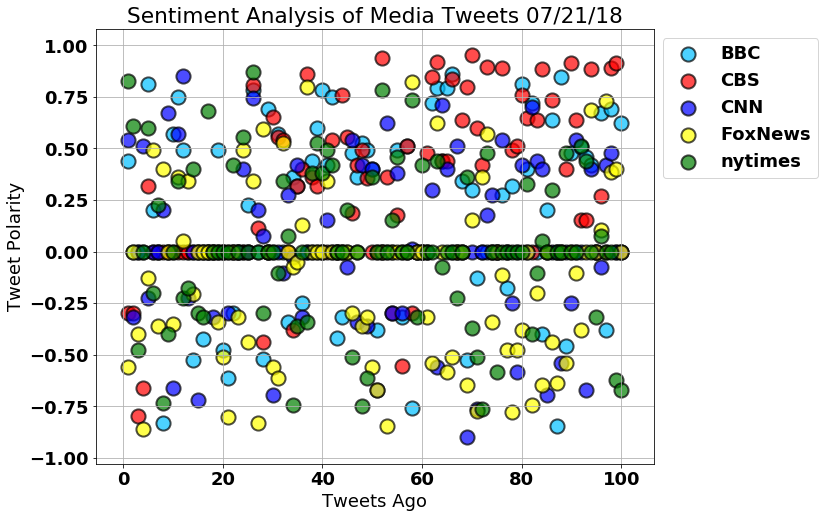

In [6]:
font = {'family':'DejaVu Sans','weight':'bold','size':18}
matplotlib.rc('font',**font)
colors = ['deepskyblue','red','blue','yellow','green']
plt.figure(figsize=(10,8))
DTtoday = datetime.date.today()
DTtoday_str = DTtoday.strftime("%m/%d/%y")
for ti, target_user in enumerate(target_users):
    plt.scatter( p_MDF.index.tolist(), p_MDF[target_user], s=200, \
                 label=target_user, alpha=0.7, c=colors[ti], edgecolors='k', linewidth=2 )
plt.title('Sentiment Analysis of Media Tweets ' + DTtoday_str)
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.savefig('ScatterPlot.png')


In [7]:
BDF = MDF.groupby(['Screen Name'])[['Compound sentiment scores']].mean()

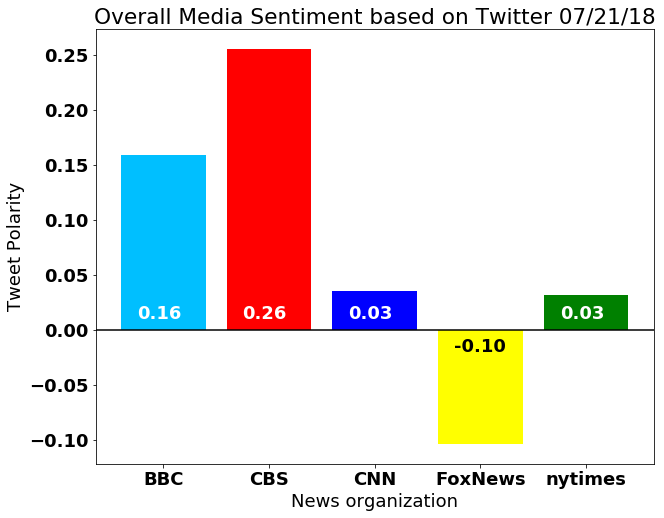

In [8]:
plt.figure(figsize=(10,8))
plt.bar(BDF.index.tolist(),BDF['Compound sentiment scores'],color=colors)
plt.axhline(y=0, color='k')
for i, v in enumerate(BDF['Compound sentiment scores']):
    if v > 0:
        plt.text(i-0.25,0.01,'{:.2f}'.format(v),color='w')
    else:
        plt.text(i-0.25,-0.02,'{:.2f}'.format(v),color='k')
plt.xlabel('News organization')
plt.ylabel('Tweet Polarity')
plt.title('Overall Media Sentiment based on Twitter '+ DTtoday_str)
plt.savefig('BarPlot.png')